# 任务目标
1. 识别硬币的边缘
2. 通过RANSC拟合出硬币的半径
## 解决步骤
1. 读取图片
1.1 img = plt.imread("figure.jpg")
1.2 将三维变成一维数据，方便处理，可采用全部三维数据平均或者加权平均。
2. 边缘检测（canny算法）
2.1 高斯模糊：使用高斯模板去除一些异常点。
2.2 边缘检测：使用prewitt模板来卷积得到边缘。
    注意：这里的卷积使用的是对应元素点乘，而不是矩阵乘法，尽管矩阵乘法也OK。
2.3 非极大值抑制：缩小边缘特征，根据每个点的梯度方向进行抑制。
    注意：两种方法，第一，直接划分八个区域，将梯度方向简化。第二，线性插值，使用tan比值计算。
2.4 简化边缘：使用双阈值的办法，删除弱边缘。
    注意：使用深度搜索查询算法。并且使用集合来提高查询效率。
3. 拟合硬币的半径（霍夫变换）
3.1 边缘梯度：对简化边缘之后的二值图使用sobel算子进行x和y两个梯度方向的检测，确定x和y两个方向的梯度强度。
    注意：这里最好使用简化边缘之后的二值图，另外将x和y两个方向的梯度强度分别储存，方便后续投票确定圆心。
3.2 确定圆心：canny算法确定之后的边缘图，对每一个边缘点进行检测，每个点都会从x和y方向上进行投票。最终留下投票数较多的圆心。
    注意：由于很多点的边缘梯度其实并不完全统一，这里可以使用高斯滤波来进行平滑，需要注意两个圆心距离过近的话，认为是同一个圆，从而进行极大值抑制。
3.3 确定半径：根据之前筛选出来的圆心坐标，遍历简化边缘图上的边缘点，计算到圆心的距离，给半径投票。
    注意：不需要遍历所有点，只需要遍历最大半径范围内的点。
## Notes
1. numpy
2. matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [416]:
img = plt.imread("./4.jpg")
img = np.array(img)
print(img.shape)

(466, 474, 3)


In [417]:
# Dimension Reduction
a, b, c = img.shape
new_img = np.zeros(shape=(a, b))
print(new_img.shape)
for i in range(a):
    for j in range(b):
        new_img[i, j] = img[i, j].mean()


(466, 474)


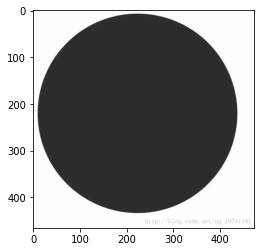

In [418]:
plt.imshow(new_img, cmap="gray")

In [419]:
# 2. Edge Dectection: y: [[-1, -1, -1], [0, 0, 0], [1, 1, 1]], x: [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
# [
# [new_img[i-1, j-1], new_img[i-1, j], new_img[i-1, j+1]], 
# [new_img[i, j-1], new_img[i, j], new_img[i, j+1]], 
# [new_img[i+1, j-1], new_img[i+1, j], new_img[i+1, j+1]]
# ]
conv_img = np.zeros(shape=(a, b))
conv_theta = np.zeros(shape=(a, b))
conv_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
conv_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
for i in range(1, a-1):
    for j in range(1, b-1):
        cell = np.array([
        [new_img[i-1, j-1], new_img[i-1, j], new_img[i-1, j+1]], 
        [new_img[i, j-1], new_img[i, j], new_img[i, j+1]], 
        [new_img[i+1, j-1], new_img[i+1, j], new_img[i+1, j+1]]
        ])
        conv_img_x = np.sum(conv_x * cell)
        conv_img_y = np.sum(conv_y * cell) # 卷积使用对应元素点乘
        conv_img[i, j] = np.sqrt(conv_img_x**2+conv_img_y**2)
        conv_theta[i, j] = np.arctan(conv_img_y / conv_img_x)

C:\Users\weitao\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\weitao\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


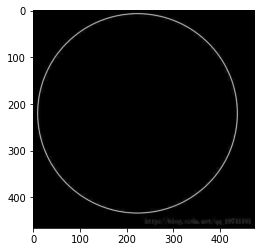

In [420]:
plt.imshow(conv_img, cmap="gray")

In [421]:
# 非极大值抑制
# 1. 使用周围的点来对比，效果一般。
# for i in range(1, a-1):
#     for j in range(1, b-1):
#         if 0 <= conv_theta[i, j] < np.pi/4 or -np.pi < conv_theta[i, j] < -np.pi * 3 / 4:
#             conv_img[i, j] = max(conv_img[i, j], conv_img[i, j+1], conv_img[i-1, j+1], conv_img[i+1, j-1], conv_img[i, j-1]) if conv_img[i, j] == max(conv_img[i, j], conv_img[i-1, j+1], conv_img[i, j+1], conv_img[i+1, j-1], conv_img[i, j-1]) else 0
#         if np.pi/4 <= conv_theta[i, j] < np.pi/2 or -np.pi * 3 / 4 < conv_theta[i, j] < -np.pi / 2:
#             conv_img[i, j] = max(conv_img[i, j], conv_img[i-1, j+1], conv_img[i-1, j], conv_img[i+1, j-1], conv_img[i+1, j]) if conv_img[i, j] == max(conv_img[i, j], conv_img[i-1, j+1], conv_img[i-1, j], conv_img[i+1, j-1], conv_img[i+1, j]) else 0
#         if np.pi/2 <= conv_theta[i, j] < np.pi*3/4 or -np.pi/2 < conv_theta[i, j] < -np.pi/4:
#             conv_img[i, j] = max(conv_img[i, j], conv_img[i-1, j], conv_img[i-1, j-1], conv_img[i+1, j], conv_img[i+1, j+1]) if conv_img[i, j] == max(conv_img[i, j], conv_img[i-1, j], conv_img[i-1, j-1], conv_img[i+1, j], conv_img[i+1, j+1]) else 0
#         if np.pi*3/4 <= conv_theta[i, j] < np.pi or -np.pi/4 < conv_theta[i, j] < 0:
#             conv_img[i, j] = max(conv_img[i-1, j-1], conv_img[i, j-1], conv_img[i+1, j+1], conv_img[i, j+1]) if conv_img[i, j] == max(conv_img[i-1, j-1], conv_img[i, j-1], conv_img[i+1, j+1], conv_img[i, j+1]) else 0
# 2. 使用线性插值
# np.max里面放入的必须为array
for i in range(1, a-1):
    for j in range(1, b-1):
        if 0 <= conv_theta[i, j] < np.pi/4 or -np.pi < conv_theta[i, j] < -np.pi * 3 / 4:
            up = (1-np.tan(abs(conv_theta[i, j]))) * conv_img[i, j+1] + np.tan(abs(conv_theta[i, j])) * conv_img[i-1, j+1]
            down = (1-np.tan(abs(conv_theta[i, j]))) * conv_img[i, j-1] + np.tan(abs(conv_theta[i, j])) * conv_img[i+1, j-1]
            conv_img[i, j] = conv_img[i, j] if conv_img[i, j] >= max(up, down) else 0
        if np.pi/4 <= conv_theta[i, j] < np.pi/2 or -np.pi * 3 / 4 < conv_theta[i, j] < -np.pi / 2:
            up = (1-np.tan(1/abs(conv_theta[i, j]))) * conv_img[i-1, j] + np.tan(1/abs(conv_theta[i, j])) * conv_img[i-1, j+1]
            down = (1-np.tan(1/abs(conv_theta[i, j]))) * conv_img[i-1, j] + np.tan(1/abs(conv_theta[i, j])) * conv_img[i+1, j-1]
            conv_img[i, j] = conv_img[i, j] if conv_img[i, j] >= max(up, down) else 0
        if np.pi/2 <= conv_theta[i, j] < np.pi*3/4 or -np.pi/2 < conv_theta[i, j] < -np.pi/4:
            up = (1-np.tan(1/abs(conv_theta[i, j]))) * conv_img[i-1, j] + np.tan(1/abs(conv_theta[i, j])) * conv_img[i-1, j-1]
            down = (1-np.tan(1/abs(conv_theta[i, j]))) * conv_img[i+1, j] + np.tan(1/abs(conv_theta[i, j])) * conv_img[i+1, j+1]
            conv_img[i, j] = conv_img[i, j] if conv_img[i, j] >= max(up, down) else 0
        if np.pi*3/4 <= conv_theta[i, j] < np.pi or -np.pi/4 < conv_theta[i, j] < 0:
            up = (1-np.tan(abs(conv_theta[i, j]))) * conv_img[i, j-1] + np.tan(abs(conv_theta[i, j])) * conv_img[i-1, j-1]
            down = (1-np.tan(abs(conv_theta[i, j]))) * conv_img[i, j+1] + np.tan(abs(conv_theta[i, j])) * conv_img[i+1, j+1]
            conv_img[i, j] = conv_img[i, j] if conv_img[i, j] >= max(up, down) else 0

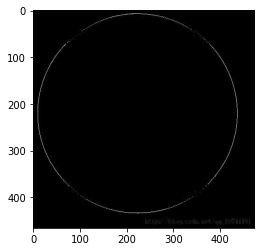

In [422]:
plt.imshow(conv_img, cmap="gray")

In [423]:
np.max(conv_img)

594.7856756849479

In [434]:
high_threshold = 160
low_threshold = 80
high_img = conv_img.copy()
low_img = conv_img.copy()
# 抑制孤立边缘
# 1. 直接检查每个点周围是否有超过高门限的点，有留下，没有置0
# for i in range(1, a-1):
#     for j in range(1, b-1):
#         cell = np.array([
#         [low_img[i-1, j-1], low_img[i-1, j], low_img[i-1, j+1]], 
#         [low_img[i, j-1], low_img[i, j], low_img[i, j+1]], 
#         [low_img[i+1, j-1], low_img[i+1, j], low_img[i+1, j+1]]
#         ])
#         low_img[i, j] = low_img[i, j] if low_img[i, j] > low_threshold else 0
#         low_img[i, j] = np.max(cell) if np.max(cell) >= high_threshold and low_img[i, j] != 0 else 0
# 2. 使用图的算法来进行检查
visited = set() # 用来计算所有遍历过的点，使用集合大大提高效率
stack = [] # 用来记录中心点
queue = [] # 用来记录弱边缘
for i in range(1, a-1):
    for j in range(1, b-1):
        if (i, j) in visited:
            continue
        visited.add((i, j))
        if high_img[i ,j] < low_threshold:
            high_img[i, j] = 0
            continue
        if high_img[i, j] >= high_threshold:
            high_img[i , j] = high_threshold
            continue
        stack.append((i, j))
        queue.append((i, j))
        connected = False
        while stack:
            t_i, t_j = stack.pop(0)
            if high_img[t_i, t_j] >= high_threshold:
                connected = True

            # 检查八个邻域是否有弱边缘
            if high_img[t_i-1, t_j-1] > low_threshold and (t_i-1, t_j-1) not in queue:
                stack.append((t_i-1, t_j-1))
                queue.append((t_i-1, t_j-1))
            if high_img[t_i-1, t_j] > low_threshold and (t_i-1, t_j) not in queue:
                stack.append((t_i-1, t_j))
                queue.append((t_i-1, t_j))
            if high_img[t_i-1, t_j+1] > low_threshold and (t_i-1, t_j+1) not in queue:
                stack.append((t_i-1, t_j+1))
                queue.append((t_i-1, t_j+1))
            if high_img[t_i, t_j-1] > low_threshold and (t_i, t_j-1) not in queue:
                stack.append((t_i, t_j-1))
                queue.append((t_i, t_j-1))
            if high_img[t_i, t_j+1] > low_threshold and (t_i, t_j+1) not in queue:
                stack.append((t_i, t_j+1))
                queue.append((t_i, t_j+1))
            if high_img[t_i+1, t_j-1] > low_threshold and (t_i+1, t_j-1) not in queue:
                stack.append((t_i+1, t_j-1))
                queue.append((t_i+1, t_j-1))
            if high_img[t_i+1, t_j] > low_threshold and (t_i+1, t_j) not in queue:
                stack.append((t_i+1, t_j))
                queue.append((t_i+1, t_j))
            if high_img[t_i+1, t_j+1] > low_threshold and (t_i+1, t_j+1) not in queue:
                stack.append((t_i+1, t_j+1))
                queue.append((t_i+1, t_j+1))
        while queue:
            i_, j_ = queue.pop(-1)
            visited.add((i_, j_))
            high_img[i_, j_] = high_threshold if connected else 0

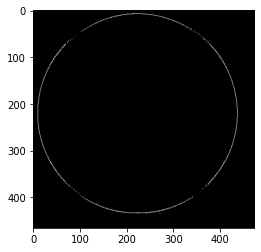

In [435]:
plt.imshow(high_img, cmap="gray")

In [436]:
# 确定二值图像的边缘梯度
conv_img_theta = np.zeros(shape=(a, b))
conv_img_theta_x = np.zeros(shape=(a, b))
conv_img_theta_y = np.zeros(shape=(a, b))
conv_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
conv_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
for i in range(1, a-1):
    for j in range(1, b-1):
        cell = np.array([
        [high_img[i-1, j-1], high_img[i-1, j], high_img[i-1, j+1]], 
        [high_img[i, j-1], high_img[i, j], high_img[i, j+1]], 
        [high_img[i+1, j-1], high_img[i+1, j], high_img[i+1, j+1]]
        ])
        conv_img_x = np.sum(conv_x * cell)
        conv_img_y = np.sum(conv_y * cell) # 卷积使用对应元素点乘
        conv_img_theta_x[i, j] = conv_img_x
        conv_img_theta_y[i, j] = conv_img_y
        conv_img_theta[i, j] = np.sqrt(conv_img_x ** 2 + conv_img_y ** 2)

In [456]:
min_dis = 200
max_dis = 300

In [457]:
step = 2
par_space = np.zeros(shape=(a, b))
guassian_filter = np.array([[0.10519, 0.11395, 0.10519], [0.11395, 0.12344, 0.11395], [0.10519, 0.11395, 0.10519]])
for i in range(1, a-1):
    for j in range(1, b-1):
        if high_img[i, j] == 0 or conv_img_theta[i, j] == 0:
            continue
        # 霍夫变换找圆，参数空间太大会导致内存不够的问题
        # 这里用高斯模板来优化实际的dx，去除不稳定
        dx = np.sum(conv_img_theta_x[i-1:i+2, j-1:j+2]*guassian_filter)
        dy = np.sum(conv_img_theta_y[i-1:i+2, j-1:j+2]*guassian_filter)
        # theta_x = conv_img_theta_x[i, j] / conv_img_theta[i, j]
        # theta_y = conv_img_theta_y[i, j] / conv_img_theta[i, j]
        theta_x = dx / np.sqrt(dx**2+dy**2)
        theta_y = dy / np.sqrt(dx**2+dy**2)
        x = i + min_dis*theta_y
        y = j + min_dis*theta_x
        while 1 < x < min(a-2, i+max_dis) and 0 < y < min(b-2, j+max_dis):
            # r = int(np.sqrt((x-i)**2 + (y-j)**2))
            # if r >= R:
                # break
            par_space[int(x)-1:int(x)+1, int(y)-1:int(y)+1] += 1
            x = x + step*theta_y
            y = y + step*theta_x
        x = i - min_dis*theta_y
        y = j - min_dis*theta_x
        while max(i-max_dis, 1) < x < a-2 and max(j-max_dis, 0) < y < b-2:
            par_space[int(x)-1:int(x)+1, int(y)-1:int(y)+1] += 1
            x = x - step*theta_y
            y = y - step*theta_x

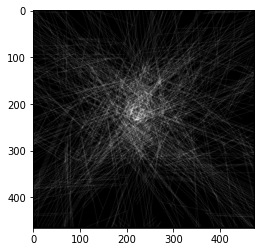

In [458]:
plt.imshow(par_space, cmap="gray")

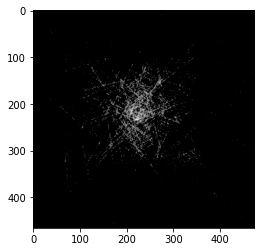

In [459]:
new_par_space = par_space.copy()
for i in range(a):
    for j in range(b):
        new_par_space[i, j] = new_par_space[i, j] if new_par_space[i, j] > 5 else 0
plt.imshow(new_par_space, cmap="gray")

In [460]:
# 拿到可能的圆心，两个圆心最近距离200，最小半径100，最大半径150
candidate = {}
while np.max(new_par_space) != 0:
    max_index, max_val = np.unravel_index(new_par_space.argmax(), new_par_space.shape), np.max(new_par_space)
    x, y = max_index
    flag = True
    if candidate:
        for index in candidate:
            x_, y_ = index
            if (x-x_)**2 + (y-y_)**2 < (2*min_dis)**2:
                flag = False
                break
    if flag:
        candidate[max_index] = max_val
    new_par_space[max(0, x-50):min(a, x+50), max(0, y-50): min(b, y+50)] = 0

In [461]:
print(len(candidate))

1


In [462]:
# candidate非空
# 投半径
core = {}
for cell in candidate:
    radius = np.zeros(shape=(max_dis+1, 1))
    x_i, y_i = cell
    for i in range(max(0, x_i-max_dis), min(a, x_i+max_dis)):
        for j in range(max(0, y_i-max_dis), min(b, y_i+max_dis)):
            if high_img[i, j] != 0 and conv_img_theta[i, j] != 0:
                r = np.sqrt((i-x_i)**2 + (j-y_i)**2)
                if min_dis <= r <= max_dis:
                    radius[int(r)] += 1
    if np.max(radius) > 10:
        core[cell] = (np.argmax(radius), np.max(radius))
    else:
        core[cell] = (np.argmax(radius), 0)

In [463]:
print(len(core))

1


In [464]:
# 根据比例确定半径点和半径
ratio = {}
for index in core:
    if candidate.get(index):
        ratio[index] = core[index][1] / candidate.get(index)

In [465]:
sort_ratio = [[k, v] for k, v in ratio.items() if v > 0]

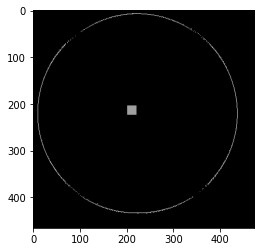

In [466]:
low_img = high_img.copy()
for item in sort_ratio:
    x, y = item[0]
    low_img[x-10:x+10, y-10:y+10] = 100
plt.imshow(low_img, cmap="gray")

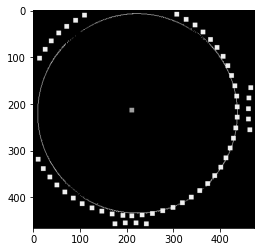

In [467]:
low_img = high_img.copy()
for item in sort_ratio:
    a, b = item[0]
    r = core[item[0]][0]
    low_img[a-5:a+5, b-5:b+5] = 100
    for theta in np.arange(0, 2*np.pi, 0.1):
        x = int(a+r*np.cos(theta))
        y = int(b+r*np.sin(theta))
        low_img[x-5:x+5, y-5:y+5] = 150
plt.imshow(low_img, cmap="gray")